<a href="https://colab.research.google.com/github/JaoSaraiva/-Engenhando-com-Dados/blob/main/ml_prev_fraude_engjao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
df_original = pd.read_csv('/content/dados_coletados10k.csv')

## Análise Exploratória - Dados de Empréstimo Financeiro

In [ ]:
##Tamanho do conjunto de dados. xx.xxx linhas e xx variáveis
df_original.shape

(9517, 24)

In [ ]:
##Variável alvo 'Possivel_Fraude'
df_original.head()

,Contrato,Idade,Sexo,Valor_Renda,UF_Cliente,Perc_Juros,Prazo_Emprestimo,Data_Contratacao,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Escolaridade,Possui_Patrimonio,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago,Possivel_Fraude
0,322068935715,43,M,5800.00,SP,23.00,200,2022-08-01,193,80000.00,92000.00,15,9,1,0,DIVORCIADO,Nenhum,N,0.00,0,NaN,91759.97,7717.08,Nao
1,322068936715,22,M,2000.00,MG,20.00,100,2022-08-01,89,50000.00,57500.00,10,10,0,0,SOLTEIRO(A),NaN,N,0.00,4,103.00,53981.18,6756.59,Nao
2,322068938715,35,M,4000.00,BA,18.00,100,2022-08-01,85,100000.00,115000.00,15,5,1,0,CASADO (A),NaN,N,0.00,0,NaN,101150.02,17929.06,Nao
3,322068939715,20,M,1800.00,MG,20.00,100,2022-08-01,89,30000.00,34500.00,1,1,0,0,SOLTEIRO(A),NaN,N,0.00,13,376.00,36208.10,369.10,Sim
4,322068940715,53,M,2800.00,MG,20.00,100,2022-08-01,87,60000.00,69000.00,16,16,0,0,CASADO (A),NaN,N,0.00,0,NaN,60984.00,11845.24,Nao


In [ ]:
inicio = pd.to_datetime(df_original['Data_Contratacao']).dt.date.min()
fim = pd.to_datetime(df_original['Data_Contratacao']).dt.date.max()
print('Período dos dados - De:', inicio, 'Até:',fim)

Período dos dados - De: 2022-07-04 Até: 2022-12-20


In [ ]:
df_original.isnull().sum()

Contrato                               0
Idade                                  0
Sexo                                   0
Valor_Renda                            0
UF_Cliente                             0
Perc_Juros                             0
Prazo_Emprestimo                       0
Data_Contratacao                       0
Prazo_Restante                         0
VL_Emprestimo                          0
VL_Emprestimo_ComJuros                 0
QT_Total_Parcelas_Pagas                0
QT_Total_Parcelas_Pagas_EmDia          0
QT_Total_Parcelas_Pagas_EmAtraso       0
Qt_Renegociacao                        0
Estado_Civil                           0
Escolaridade                        7105
Possui_Patrimonio                      0
VL_Patrimonio                          0
QT_Parcelas_Atraso                     0
QT_Dias_Atraso                      3594
Saldo_Devedor                          0
Total_Pago                             0
Possivel_Fraude                        0
dtype: int64

In [ ]:
##Tipos de variáveis sem barra de rolamento
df_original.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Contrato                          9517 non-null   int64  
 1   Idade                             9517 non-null   int64  
 2   Sexo                              9517 non-null   object 
 3   Valor_Renda                       9517 non-null   float64
 4   UF_Cliente                        9517 non-null   object 
 5   Perc_Juros                        9517 non-null   float64
 6   Prazo_Emprestimo                  9517 non-null   int64  
 7   Data_Contratacao                  9517 non-null   object 
 8   Prazo_Restante                    9517 non-null   int64  
 9   VL_Emprestimo                     9517 non-null   float64
 10  VL_Emprestimo_ComJuros            9517 non-null   float64
 11  QT_Total_Parcelas_Pagas           9517 non-null   int64  
 12  QT_Tot

In [ ]:
# Total de valores únicos de cada variável
# A variável CONTRATO é um valor único para cada registro, pois refere-se ao Contrato do Cliente
valores_unicos = []
for i in df_original.columns[0:24].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))

Contrato : 9517
Idade : 74
Sexo : 2
Valor_Renda : 855
UF_Cliente : 27
Perc_Juros : 21
Prazo_Emprestimo : 36
Data_Contratacao : 110
Prazo_Restante : 79
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 6
Escolaridade : 6
Possui_Patrimonio : 2
VL_Patrimonio : 3
QT_Parcelas_Atraso : 16
QT_Dias_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Possivel_Fraude : 2


In [ ]:
##Informações Estatísticas

df_original.describe()

,Contrato,Idade,Valor_Renda,Perc_Juros,Prazo_Emprestimo,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,5923.00,9517.00,9517.00
mean,322078158460.93,38.74,8325.40,19.65,107.43,104.58,81881.89,94164.17,7.89,4.11,1.60,1.24,10.93,5.35,249.79,90560.27,8166.21
std,5434160.86,12.67,121862.06,3.82,62.49,68.57,94138.06,108258.77,5.17,4.04,2.31,1.17,1025.26,5.32,123.22,111050.54,16697.76
min,322068935715.00,6.00,450.00,7.00,15.00,0.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00
25%,322073331715.00,29.00,2300.00,18.00,60.00,51.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,0.00,162.00,18546.85,1202.04
50%,322078461715.00,37.00,3400.00,20.00,80.00,80.00,50000.00,57500.00,9.00,2.00,1.00,1.00,0.00,4.00,284.00,45375.30,3949.91
75%,322082622715.00,46.00,5000.00,22.00,190.00,185.00,100000.00,115000.00,13.00,6.00,2.00,2.00,0.00,11.00,344.00,119721.25,8302.01
max,322087622715.00,91.00,8000080.00,28.00,240.00,227.00,500000.00,575000.00,35.00,35.00,14.00,9.00,100000.00,15.00,435.00,625000.00,396385.00


In [ ]:
print('Maior Renda:', df_original['Valor_Renda'].max())
print('Menor Renda:', df_original['Valor_Renda'].min())

print('Maior quantidade de dias atraso: ', df_original['QT_Dias_Atraso'].max())
print('Menor quantidade de dias atraso: ', df_original['QT_Dias_Atraso'].min())

print('Maior quantidade de dias restante: ', df_original['Prazo_Restante'].max())
print('Menor quantidade de dias restante: ', df_original['Prazo_Restante'].min())

Maior Renda: 8000080.0
Menor Renda: 450.0
Maior quantidade de dias atraso:  435.0
Menor quantidade de dias atraso:  11.0
Maior quantidade de dias restante:  227
Menor quantidade de dias restante:  0


In [ ]:
##Quantidade de dias x número de clientes
df_original.groupby(['QT_Dias_Atraso']).size()

QT_Dias_Atraso
11.00     532
41.00     255
71.00     190
103.00    205
133.00    176
162.00    206
194.00    241
225.00    352
251.00    471
284.00    546
315.00    718
344.00    930
376.00    686
406.00    413
435.00      2
dtype: int64

In [ ]:
# Prazo emprestimo x número de cliente
df_original.groupby(['Prazo_Emprestimo']).size()

Prazo_Emprestimo
15        4
18        4
19        5
20      146
25      183
30      272
34        1
35       81
36      306
40      136
42       20
45      205
48      333
50      184
55      185
60      890
65       36
70      134
75      455
80     1421
88        2
90      354
95      135
100     928
120     102
130      21
140     167
150      48
160      33
165       3
170      78
180     129
190     674
200    1661
235      71
240     110
dtype: int64

In [ ]:
df_original.groupby(['Prazo_Restante']).size()

Prazo_Restante
0        2
3        3
4        2
6       22
7       29
8       31
9        8
10      12
11      32
12       6
13      94
15      10
16      42
17      85
18      27
19     143
20      23
23     164
25      84
27      38
28      52
29      71
30      51
31      71
33      40
34      67
35     168
36     204
37      31
38      55
39      22
40      73
41      37
42      14
43      27
44     126
45      19
46       2
49     145
50      19
51     256
53     150
59       7
60     178
64     421
66      43
68     330
71     270
74     304
75     193
76      99
77      67
78      63
79      86
80     188
82     159
84      48
85      72
87     129
89     420
91     705
100     15
107     43
120     24
125     68
129     44
133     25
143    197
149     16
156     39
159     58
175    119
179     27
185    332
193    764
198    337
221     17
225    534
227    519
dtype: int64

In [ ]:
df_original.groupby(['Sexo']).size()

Sexo
F    3811
M    5706
dtype: int64

In [ ]:
df_original.groupby(['UF_Cliente']).size()

UF_Cliente
AC       1
AL      79
AM       2
AP       5
BA     883
CE     248
DF      46
ES      49
GO     485
MA     403
MG    1637
MS     238
MT     137
PA     420
PB     154
PE     263
PI     104
PR     693
RJ     335
RN      78
RO      16
RR       4
RS     407
SC     298
SE      45
SP    2468
TO      19
dtype: int64

In [ ]:
## Aqui observamos que clientes possuem idades que fogem das regras de empréstimo. Provavelmente estejamos lidando com
## um erro de coleta de dados.

df_original.groupby(['Idade']).size()

Idade
6       1
17      4
18      6
19    109
20    207
21    193
22    173
23    234
24    251
25    253
26    296
27    277
28    280
29    298
30    284
31    281
32    288
33    273
34    310
35    336
36    280
37    262
38    271
39    270
40    264
41    270
42    243
43    233
44    285
45    229
46    208
47    177
48    167
49    172
50    148
51    143
52    118
53    122
54    124
55    124
56     96
57     76
58     90
59     79
60     99
61     71
62     56
63     49
64     54
65     37
66     65
67     39
68     48
69     33
70     27
71     16
72     19
73     16
74     16
75      7
76     12
77      5
78      5
79      3
80      9
81      5
82      3
83      4
84      2
85      5
87      2
88      2
90      2
91      1
dtype: int64

In [ ]:
df_original.groupby(['Estado_Civil']).size()

Estado_Civil
CASADO (A)       3027
DIVORCIADO        481
OUTRO             652
SOLTEIRO(A)      5087
UNIÃO ESTAVEL     130
VIÚVO(A)          140
dtype: int64

In [ ]:
df_original.groupby(['Escolaridade']).size()

Escolaridade
Ensino Fundamental                        18
Ensino Médio                             129
Ensino Superior                           74
Nenhum                                  2184
Pós Graduação / Mestrado / Doutorado       7
dtype: int64

In [ ]:
## Aqui observamos que a quantidade de clientes que não possuem patrimônio é muito discrepante. Provavelmente estejamos lidando com
## um erro de coleta de dados.

df_original.groupby(['Possui_Patrimonio']).size()

Possui_Patrimonio
N    9452
S      65
dtype: int64

In [ ]:
## Nestes dados conseguimos observar que há discrepância entre valor do patrimônio e quantidade de clientes. Esta coluna iremos excluir
## na etapa de tratamento dos dados por não agregar em nada nosso projeto.

df_original.groupby(['VL_Patrimonio']).size()

VL_Patrimonio
0.00         9512
1000.00         4
100000.00       1
dtype: int64

In [ ]:
df_original.groupby(['Possivel_Fraude']).size()

Possivel_Fraude
Nao    5035
Sim    4482
dtype: int64

## Tratando os dados

In [ ]:
df_original['Estado_Civil'] = df_original['Estado_Civil'].replace(['NENHUM'], 'OUTRO')
df_original['Estado_Civil'] = df_original['Estado_Civil'].replace(['UNIÃO ESTAVEL'], 'CASADO (A)')

df_original.groupby(['Estado_Civil']).size()

Estado_Civil
CASADO (A)     3157
DIVORCIADO      481
OUTRO           652
SOLTEIRO(A)    5087
VIÚVO(A)        140
dtype: int64

In [ ]:
## Utilizando engenharia de atributos para fazer o tratamento da coluna Faixa_Etaria e eliminiar os outliers e a visualização dos dados.
bins = [0, 21, 30, 40, 50, 60, 100]
labels = ['Até 21 Anos', 'De 22 até 30 Anos', 'De 31 até 40 Anos', 'De 41 até 50 Anos', 'De 51 até 60', 'Acima de 60 Anos']
df_original['Faixa_Etaria'] = pd.cut(df_original['Idade'], bins=bins, labels=labels)
df_original.groupby(['Faixa_Etaria']).size()

Faixa_Etaria
Até 21 Anos           520
De 22 até 30 Anos    2346
De 31 até 40 Anos    2835
De 41 até 50 Anos    2132
De 51 até 60         1071
Acima de 60 Anos      613
dtype: int64

In [ ]:
bins = [-100, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 9000000000] #foi utilizado -100 para o 0 poder entrar na contagem. Poderia ser - 1 ou - 10 tmb.
labels = ['Até 1k', 'De 1k até 2k', 'De 2k até 3k', 'De 3k até 5k', 'De 5k até 10k', 'De 10k até 20k',
          'De 20k até 30k', 'Acima de 50k']
df_original['Faixa_Salarial'] = pd.cut(df_original['Valor_Renda'], bins=bins, labels=labels)
df_original.groupby(['Faixa_Salarial']).size()

Faixa_Salarial
Até 1k              19
De 1k até 2k      2012
De 2k até 3k      2522
De 3k até 5k      2646
De 5k até 10k     1574
De 10k até 20k     488
De 20k até 30k     137
Acima de 50k       119
dtype: int64

In [ ]:
# Precisamos tratar os valores nulos dessa variavel antes de fazermos nossa engenharia de atributos
# Vamos preencher os valores nulos usando a mediana dos dados
df_original['QT_Dias_Atraso'].median()

284.0

In [ ]:
# Preenchendo os valores nulo com a mediana
df_original['QT_Dias_Atraso'] = df_original['QT_Dias_Atraso'].fillna((df_original['QT_Dias_Atraso'].median()))

In [ ]:
# Criando faixa de dias em atraso da cota para utilizarmos no modelo preditivo
bins = [-100, 30, 60, 90, 180, 240, 360, 500]
labels = ['Até 30 dias', 'De 31 até 60', 'De 61 até 90', 'De 91 até 180', 'De 181 até 240','De 241 até 360', 'Acima de 360']
df_original['Faixa_Dias_Atraso'] = pd.cut(df_original['QT_Dias_Atraso'], bins=bins, labels=labels)
df_original.groupby(['Faixa_Dias_Atraso']).size()

Faixa_Dias_Atraso
Até 30 dias        532
De 31 até 60       255
De 61 até 90       190
De 91 até 180      587
De 181 até 240     593
De 241 até 360    6259
Acima de 360      1101
dtype: int64

In [ ]:
# Criando faixa de prazo de emprestimo para utilizarmos no modelo preditivo
bins = [0, 60, 120, 200, 720]
labels = ['Até 60 Meses', 'De 61 até 120 Meses', 'De 121 até 200 Meses', 'Acima de 200 Meses']
df_original['Faixa_Prazo_Emprestimo'] = pd.cut(df_original['Prazo_Emprestimo'], bins=bins, labels=labels)
pd.value_counts(df_original.Faixa_Prazo_Emprestimo)

Faixa_Prazo_Emprestimo
De 61 até 120 Meses     3567
Até 60 Meses            2955
De 121 até 200 Meses    2814
Acima de 200 Meses       181
Name: count, dtype: int64

In [ ]:
# Criando faixa de prazo restante do emprestimo para utilizarmos no modelo preditivo
bins = [-1, 60, 120, 200, 500]
labels = ['Até 60 Meses', 'De 61 até 120 Meses', 'De 121 até 200 Meses', 'Acima de 200 Meses']
df_original['Faixa_Prazo_Restante'] = pd.cut(df_original['Prazo_Restante'], bins=bins, labels=labels)
pd.value_counts(df_original.Faixa_Prazo_Restante)

Faixa_Prazo_Restante
De 61 até 120 Meses     3679
Até 60 Meses            2742
De 121 até 200 Meses    2026
Acima de 200 Meses      1070
Name: count, dtype: int64

## Vizualizando os tratamentos em gráficos

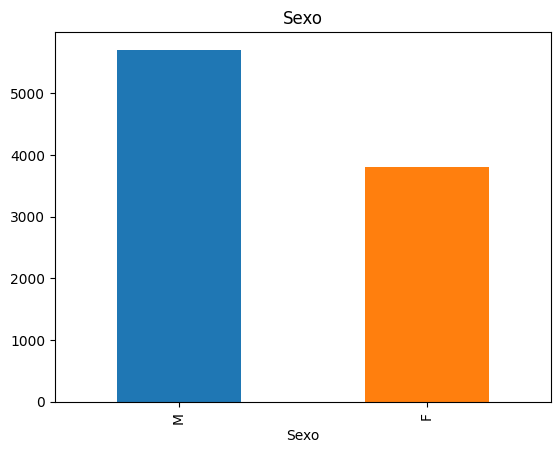

In [ ]:
df_original.Sexo.value_counts().plot(kind='bar', title='Sexo',color = ['#1F77B4', '#FF7F0E']);

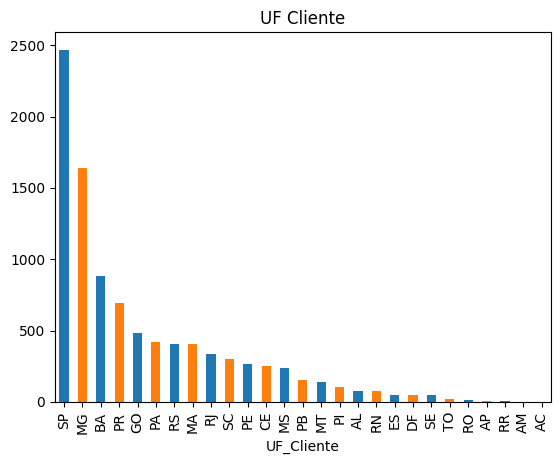

In [ ]:
df_original.UF_Cliente.value_counts().plot(kind='bar', title='UF Cliente',color = ['#1F77B4', '#FF7F0E']);

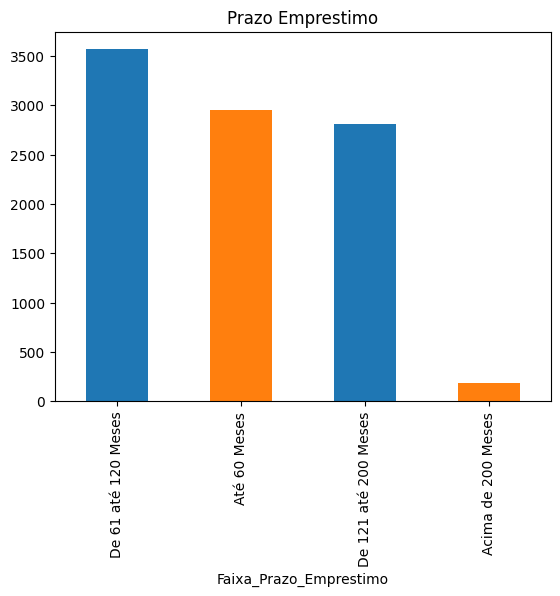

In [ ]:
df_original.Faixa_Prazo_Emprestimo.value_counts().plot(kind='bar', title='Prazo Emprestimo',color = ['#1F77B4', '#FF7F0E']);

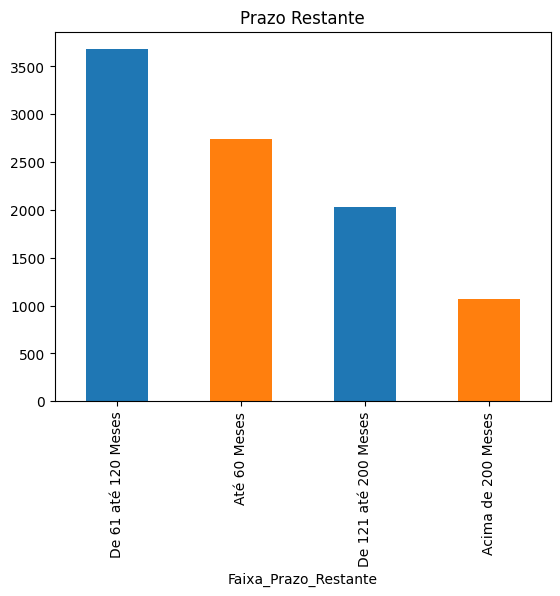

In [ ]:
df_original.Faixa_Prazo_Restante.value_counts().plot(kind='bar', title='Prazo Restante',color = ['#1F77B4', '#FF7F0E']);

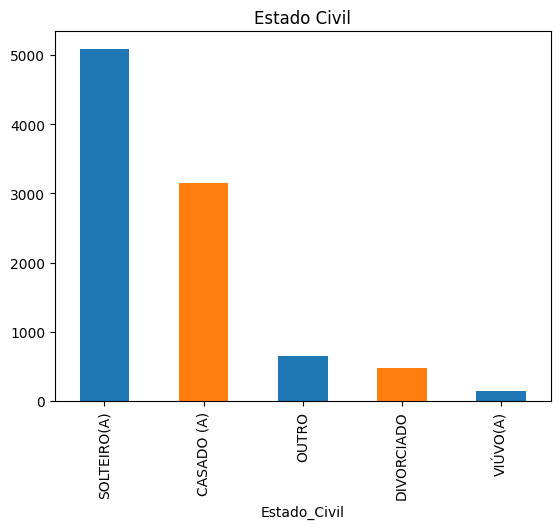

In [ ]:
df_original.Estado_Civil.value_counts().plot(kind='bar', title='Estado Civil',color = ['#1F77B4', '#FF7F0E']);

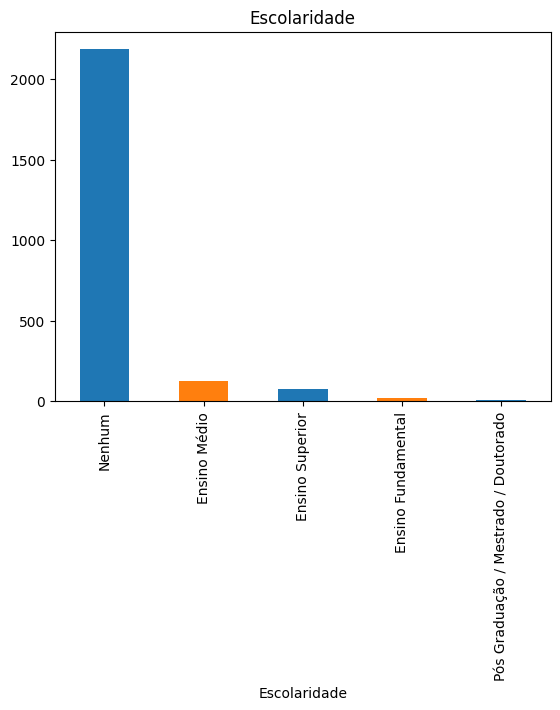

In [ ]:
df_original.Escolaridade.value_counts().plot(kind='bar', title='Escolaridade',color = ['#1F77B4', '#FF7F0E']);

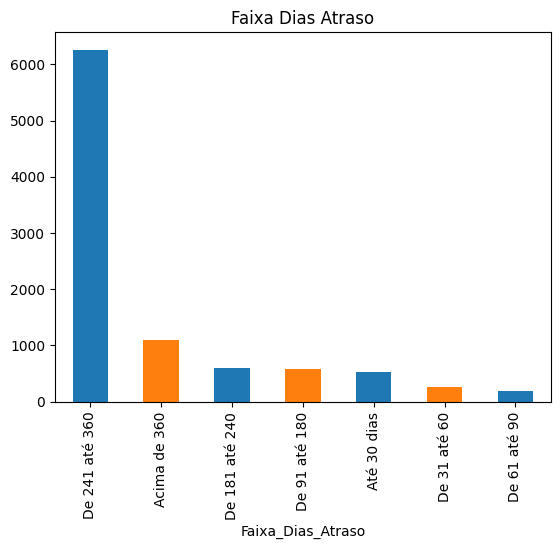

In [ ]:
df_original.Faixa_Dias_Atraso.value_counts().plot(kind='bar', title='Faixa Dias Atraso',color = ['#1F77B4', '#FF7F0E']);

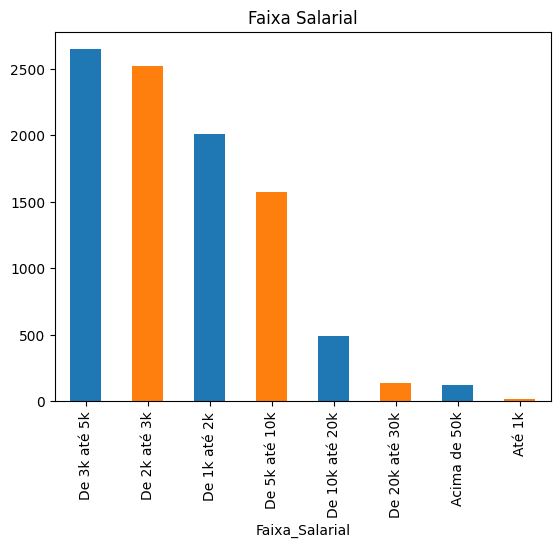

In [ ]:
df_original.Faixa_Salarial.value_counts().plot(kind='bar', title='Faixa Salarial',color = ['#1F77B4', '#FF7F0E']);

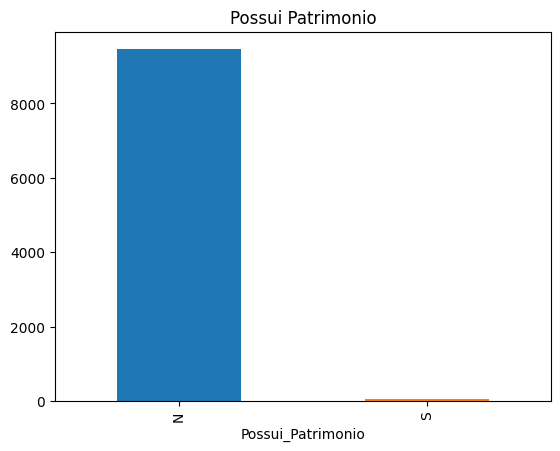

In [ ]:
df_original.Possui_Patrimonio.value_counts().plot(kind='bar', title='Possui Patrimonio',color = ['#1F77B4', '#FF7F0E']);

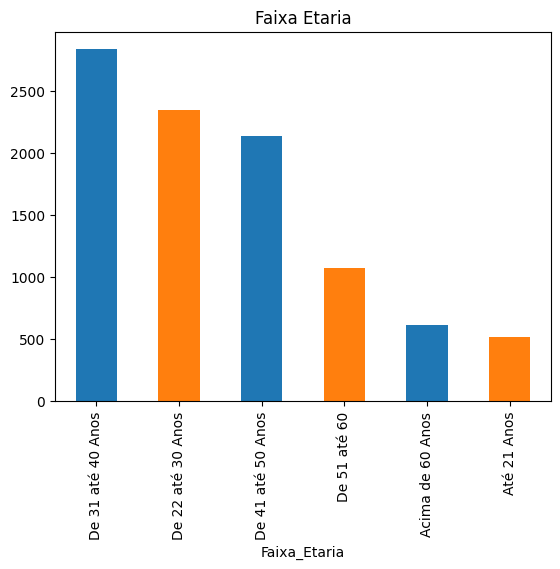

In [ ]:
df_original.Faixa_Etaria.value_counts().plot(kind='bar', title='Faixa Etaria',color = ['#1F77B4', '#FF7F0E']);

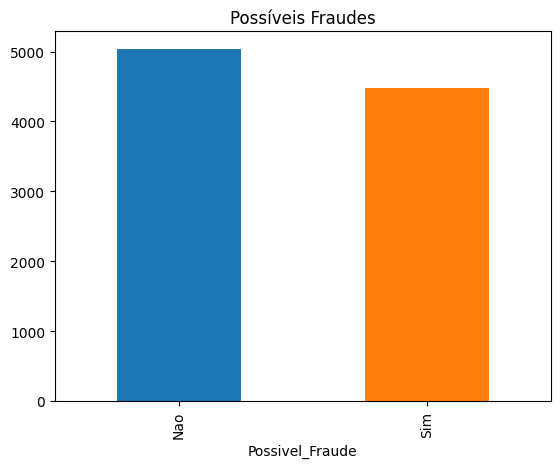

In [ ]:
#Analisando como a variavel alvo está distribuida.
#Aqui podemos observar que há muito mais cotas como NÃO POSSÍVEL FRAUDE
#dessa forma, precisaremos balancear o dataset mais adiante.
df_original.Possivel_Fraude.value_counts().plot(kind='bar', title='Possíveis Fraudes',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
# Vamos visualizar novamente como está nosso DataFrame original após a engenharia de atributos
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Contrato                          9517 non-null   int64   
 1   Idade                             9517 non-null   int64   
 2   Sexo                              9517 non-null   object  
 3   Valor_Renda                       9517 non-null   float64 
 4   UF_Cliente                        9517 non-null   object  
 5   Perc_Juros                        9517 non-null   float64 
 6   Prazo_Emprestimo                  9517 non-null   int64   
 7   Data_Contratacao                  9517 non-null   object  
 8   Prazo_Restante                    9517 non-null   int64   
 9   VL_Emprestimo                     9517 non-null   float64 
 10  VL_Emprestimo_ComJuros            9517 non-null   float64 
 11  QT_Total_Parcelas_Pagas           9517 non-null   int64 

In [ ]:
# Vamos selecionar as colunas que iremos utilizar e algumas iremos descartar
df_original.columns

Index(['Contrato', 'Idade', 'Sexo', 'Valor_Renda', 'UF_Cliente', 'Perc_Juros',
       'Prazo_Emprestimo', 'Data_Contratacao', 'Prazo_Restante',
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'Escolaridade', 'Possui_Patrimonio',
       'VL_Patrimonio', 'QT_Parcelas_Atraso', 'QT_Dias_Atraso',
       'Saldo_Devedor', 'Total_Pago', 'Possivel_Fraude', 'Faixa_Etaria',
       'Faixa_Salarial', 'Faixa_Dias_Atraso', 'Faixa_Prazo_Emprestimo',
       'Faixa_Prazo_Restante'],
      dtype='object')

In [ ]:
# APÓS ANALISE INICIAL QUE REALIZAMOS ACIMA, ENTENDEMOSO QUE ALGUMAS VARIÁVEIS NÃO POSSUEM RELEVANCIA.

#  Contrato --> Essa variável é a identificação de cada cliente
#  Data_Contratacao, VL_Patrimonio, Possui_Patrimonio, Escolaridade, Idade --> Essas não irão ter relevancia no modelo
#  Valor_Renda, Prazo_Emprestimo, QT_Dias_Atraso, Prazo_Restante --> Essas variáveis já transformamos em categoria


# Chamaremos nosso novo conjunto de dados de df_dados

columns = ['Sexo', 'UF_Cliente', 'Perc_Juros',
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'QT_Parcelas_Atraso', 'Saldo_Devedor',
       'Total_Pago', 'Faixa_Prazo_Restante', 'Faixa_Salarial', 'Faixa_Prazo_Emprestimo', 'Faixa_Etaria',
       'Faixa_Dias_Atraso', 'Possivel_Fraude']

df_dados = pd.DataFrame(df_original, columns=columns)

In [ ]:
df_dados.shape
#(linhas, colunas)

(9517, 19)

In [ ]:
df_dados.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              9517 non-null   object  
 1   UF_Cliente                        9517 non-null   object  
 2   Perc_Juros                        9517 non-null   float64 
 3   VL_Emprestimo                     9517 non-null   float64 
 4   VL_Emprestimo_ComJuros            9517 non-null   float64 
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64   
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64   
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64   
 8   Qt_Renegociacao                   9517 non-null   int64   
 9   Estado_Civil                      9517 non-null   object  
 10  QT_Parcelas_Atraso                9517 non-null   int64   
 11  Saldo_Devedor                     9517 non-null   float6

In [ ]:
# Vamos constatar que realmente não há valores nulos
df_dados.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Faixa_Prazo_Emprestimo              0
Faixa_Etaria                        0
Faixa_Dias_Atraso                   0
Possivel_Fraude                     0
dtype: int64

# Análise Exploratória em variáveis Categóricas

### Como a variável alvo **POSSIVEL_FRAUDE** está relacionada com as outras ?
### Descartaremos variáveis que não fazem sentido.

In [ ]:
# Ajustando o tamanho dos gráficos
plt.rcParams["figure.figsize"] = [10.00, 4.00]
plt.rcParams["figure.autolayout"] = True

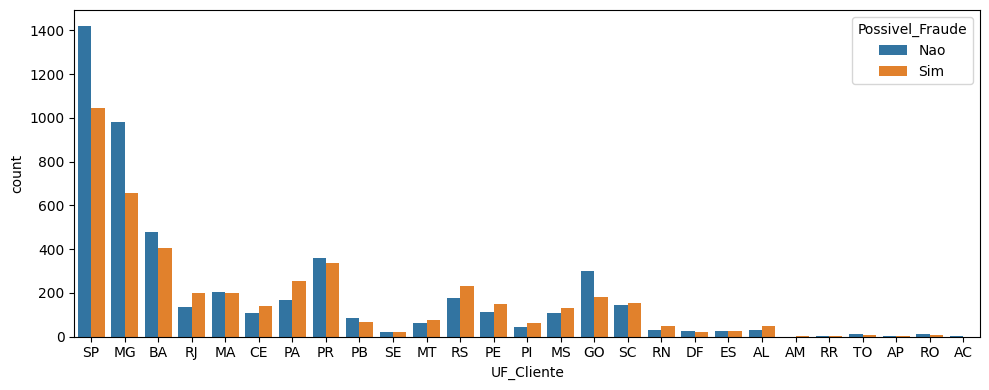

In [ ]:
#Podemos constatar na analise que não há discrepancias nestas variaveis

sns.countplot(data = df_dados, x = "UF_Cliente", hue = "Possivel_Fraude")
plt.show()

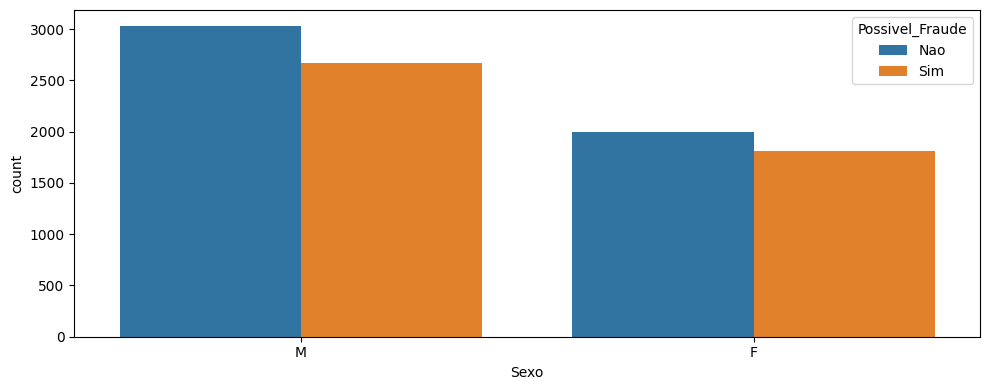

In [ ]:
#Podemos constatar na analise que não há discrepancias nestas variaveis

sns.countplot(data = df_dados, x = "Sexo", hue = "Possivel_Fraude")
plt.show()

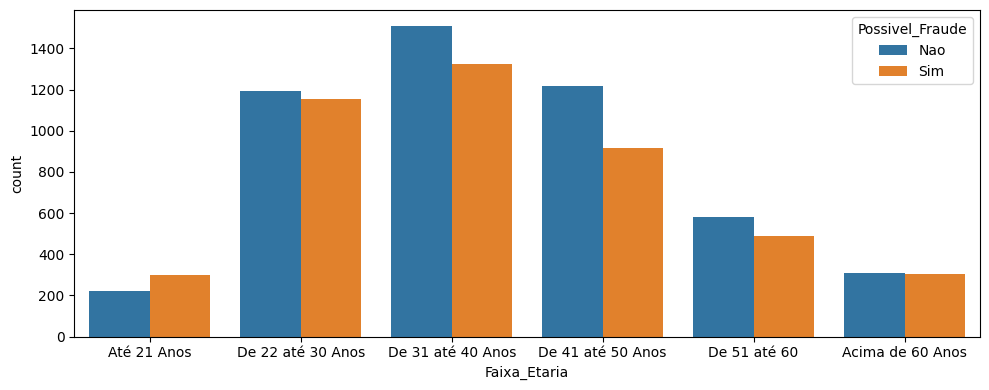

In [ ]:
#Podemos constatar na analise que não há discrepancias nestas variaveis
sns.countplot(data = df_dados, x = "Faixa_Etaria", hue = "Possivel_Fraude")
plt.show()

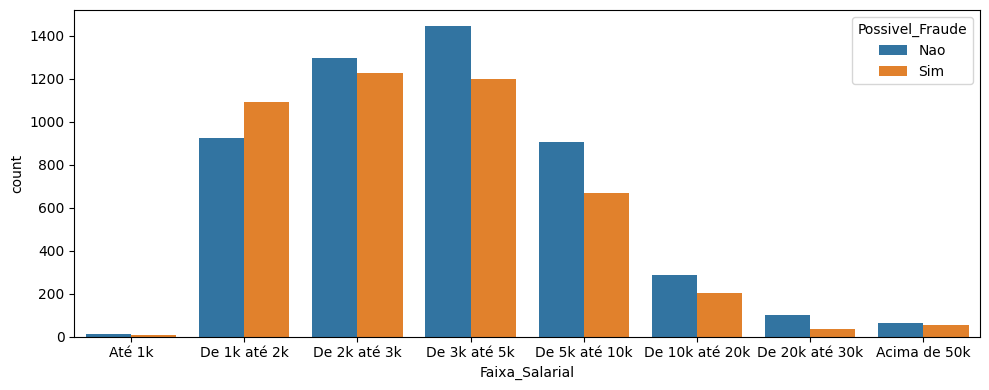

In [ ]:
#Podemos constatar na analise que não há discrepancias nestas variaveis
sns.countplot(data = df_dados, x = "Faixa_Salarial", hue = "Possivel_Fraude")
plt.show()

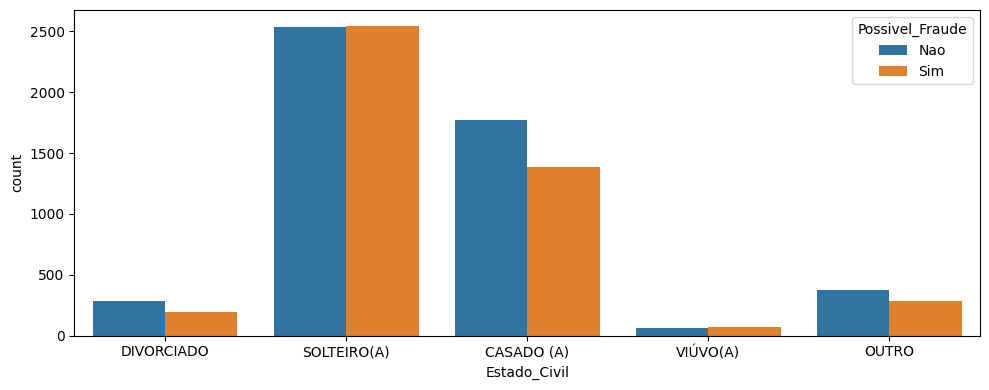

In [ ]:
#Neste caso como há muitos casos de ESTADO CIVIL diferente de Casado(C) e Solteiro(S), iremos fazer um tratamento mais adiante
#para todos casos que não forem Casado e Solteiro, serão considerado como OUTROS. Dessa forma teremos somente 3 categorias
#e os dados ficarão balanceados sem discrepancias.

sns.countplot(data = df_dados, x = "Estado_Civil", hue = "Possivel_Fraude")
plt.show()

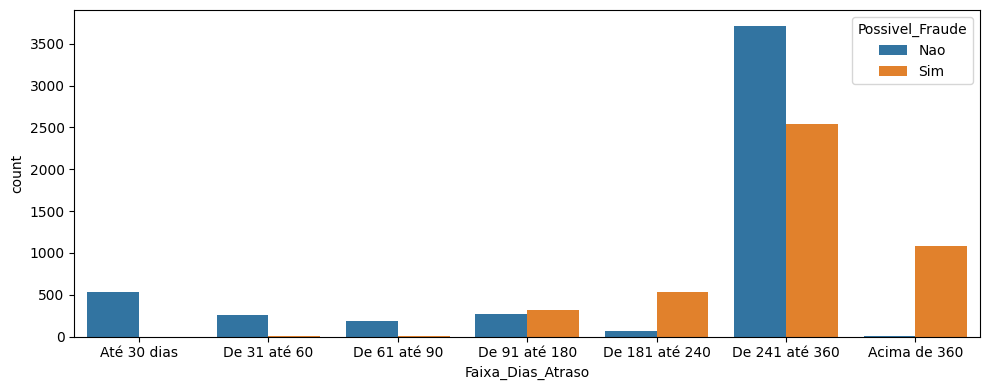

In [ ]:
#Podemos observar o volume de cotas que geraram prejuízo na arrecadação de taxa de administracao
#Essa variável iremos manter no modelo e avaliar mais adiante
sns.countplot(data = df_dados, x = "Faixa_Dias_Atraso", hue = "Possivel_Fraude")
plt.show()

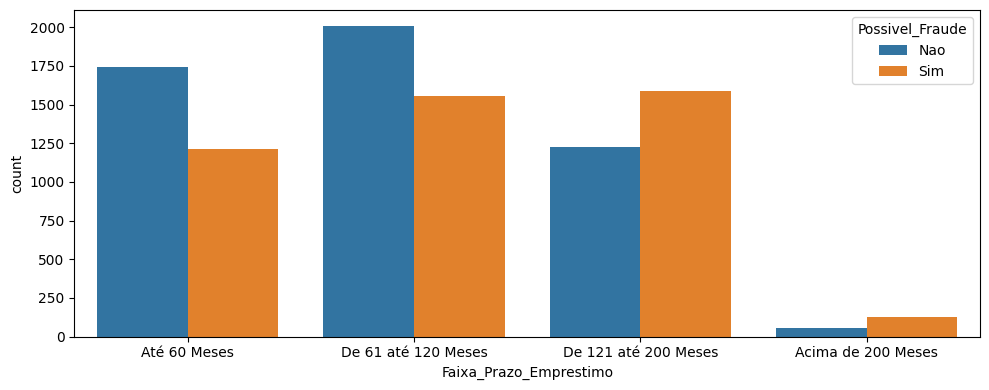

In [ ]:
# Aqui podemos observar que não há discrepancias nestas variaveis.
sns.countplot(data = df_dados, x = "Faixa_Prazo_Emprestimo", hue = "Possivel_Fraude")
plt.show()

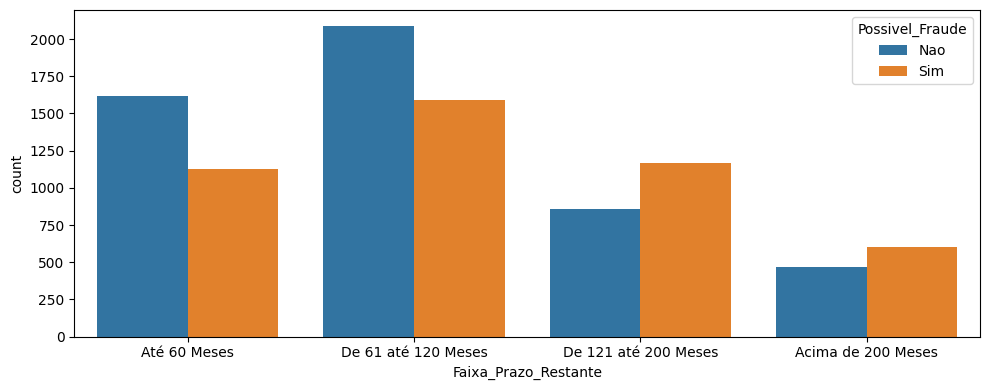

In [ ]:
# Podemos observar que esta variável está muito desbalanceada, mas iremos avaliar melhor mais adiante.
sns.countplot(data = df_dados, x = "Faixa_Prazo_Restante", hue = "Possivel_Fraude")
plt.show()

In [ ]:
# O describe não mostra as veriáveis categória,apenas as variáveis numéricas.
df_dados.describe()

,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00
mean,19.65,81881.89,94164.17,7.89,4.11,1.60,1.24,5.35,90560.27,8166.21
std,3.82,94138.06,108258.77,5.17,4.04,2.31,1.17,5.32,111050.54,16697.76
min,7.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,18546.85,1202.04
50%,20.00,50000.00,57500.00,9.00,2.00,1.00,1.00,4.00,45375.30,3949.91
75%,22.00,100000.00,115000.00,13.00,6.00,2.00,2.00,11.00,119721.25,8302.01
max,28.00,500000.00,575000.00,35.00,35.00,14.00,9.00,15.00,625000.00,396385.00


In [ ]:
# Total de valores únicos de cada variável do novo dataset
valores_unicos = []
for i in df_dados.columns[0:19].tolist():
    print(i, ':', len(df_dados[i].astype(str).value_counts()))
    valores_unicos.append(len(df_dados[i].astype(str).value_counts()))

Sexo : 2
UF_Cliente : 27
Perc_Juros : 21
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 5
QT_Parcelas_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Faixa_Prazo_Restante : 4
Faixa_Salarial : 8
Faixa_Prazo_Emprestimo : 4
Faixa_Etaria : 6
Faixa_Dias_Atraso : 7
Possivel_Fraude : 2


## Análise exploratória - Variáveis Numéricas
- Conhecimento de variáveis
- Realização de análise estatística nas variáveis para futuro tratamento, como: média, mediana, moda, desvio padrão, correlações, outliers, distribuição dos dados, etc...

In [ ]:
#carregar variaveis para plot
variaveis_numericas = []
for i in df_dados.columns[0:19].tolist():
        if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':
            variaveis_numericas.append(i)

In [ ]:
#Visualizar as variáveis numéricas
variaveis_numericas

['Perc_Juros',
 'VL_Emprestimo',
 'VL_Emprestimo_ComJuros',
 'QT_Total_Parcelas_Pagas',
 'QT_Total_Parcelas_Pagas_EmDia',
 'QT_Total_Parcelas_Pagas_EmAtraso',
 'Qt_Renegociacao',
 'QT_Parcelas_Atraso',
 'Saldo_Devedor',
 'Total_Pago']

In [ ]:
len(variaveis_numericas)
#10 colunas

10

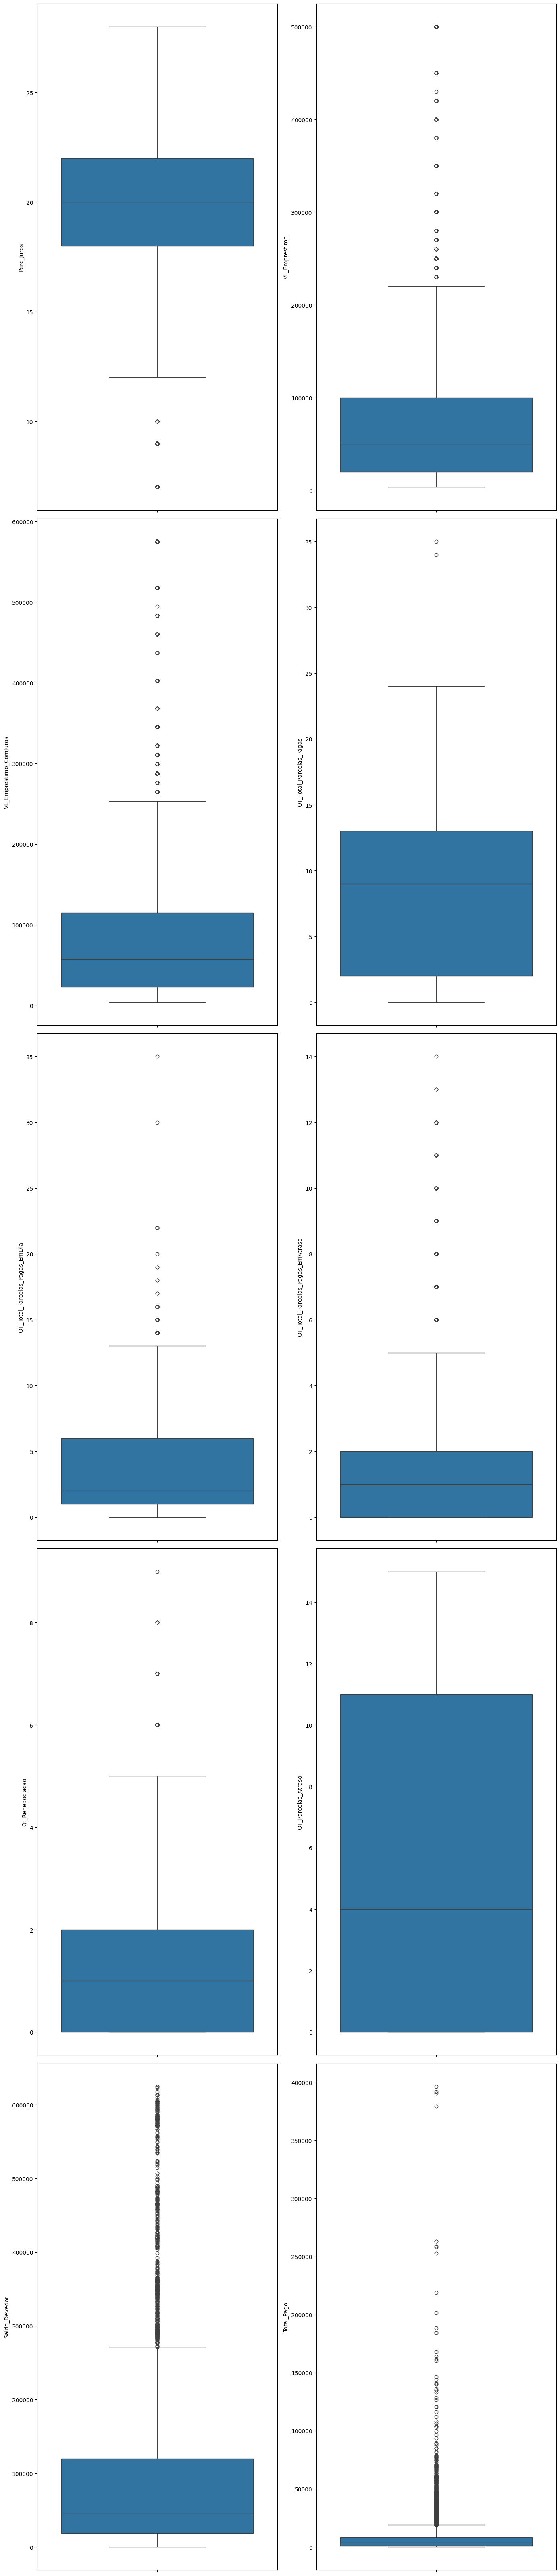

In [ ]:
#Podemos observar nos boxplots abaixo que as variáveis númericas apresentam uma grande quantidade de "possíveis" outliers
#Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier
#Estamos utilizando um comando que gera os 10 boxplots de forma automatizada

plt.rcParams["figure.figsize"] = [14.00, 64.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(5, 2) #5 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_dados, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

In [ ]:
# carregar variaveis categoricas (as que não são numéricas) para OneHotEncoding
# Vamos colocar o slice somente até a coluna de indice 18 para não pegar a variável target.
variaveis_categoricas = []
for i in df_dados.columns[0:18].tolist():
        if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':
            variaveis_categoricas.append(i)

In [ ]:
#Visualizando as variáveis categóricas
variaveis_categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Faixa_Prazo_Restante',
 'Faixa_Salarial',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Etaria',
 'Faixa_Dias_Atraso']

In [ ]:
df_dados.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso,Possivel_Fraude
0,M,SP,23.00,80000.00,92000.00,15,9,1,0,DIVORCIADO,0,91759.97,7717.08,De 121 até 200 Meses,De 5k até 10k,De 121 até 200 Meses,De 41 até 50 Anos,De 241 até 360,Nao
1,M,MG,20.00,50000.00,57500.00,10,10,0,0,SOLTEIRO(A),4,53981.18,6756.59,De 61 até 120 Meses,De 1k até 2k,De 61 até 120 Meses,De 22 até 30 Anos,De 91 até 180,Nao
2,M,BA,18.00,100000.00,115000.00,15,5,1,0,CASADO (A),0,101150.02,17929.06,De 61 até 120 Meses,De 3k até 5k,De 61 até 120 Meses,De 31 até 40 Anos,De 241 até 360,Nao
3,M,MG,20.00,30000.00,34500.00,1,1,0,0,SOLTEIRO(A),13,36208.10,369.10,De 61 até 120 Meses,De 1k até 2k,De 61 até 120 Meses,Até 21 Anos,Acima de 360,Sim
4,M,MG,20.00,60000.00,69000.00,16,16,0,0,CASADO (A),0,60984.00,11845.24,De 61 até 120 Meses,De 2k até 3k,De 61 até 120 Meses,De 51 até 60,De 241 até 360,Nao


In [ ]:
# Cria o encoder e aplica OneHotEncoder (transformar texto em número com excessão da variável principal: Possivel_Fraude)
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_dados[var] = lb.fit_transform(df_dados[var])

In [ ]:
#Verificando se ficou valores nulos
df_dados.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Faixa_Prazo_Emprestimo              0
Faixa_Etaria                        0
Faixa_Dias_Atraso                   0
Possivel_Fraude                     0
dtype: int64

In [ ]:
df_dados.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso,Possivel_Fraude
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,0,91759.97,7717.08,2,7,2,4,3,Nao
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,4,53981.18,6756.59,3,3,3,2,6,Nao
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,0,101150.02,17929.06,3,6,3,3,3,Nao
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,13,36208.10,369.10,3,3,3,1,0,Sim
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,0,60984.00,11845.24,3,5,3,5,3,Nao


In [ ]:
#Visualizando os tipos de variáveis percebemos que só a variável principal está como object
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sexo                              9517 non-null   int64  
 1   UF_Cliente                        9517 non-null   int64  
 2   Perc_Juros                        9517 non-null   float64
 3   VL_Emprestimo                     9517 non-null   float64
 4   VL_Emprestimo_ComJuros            9517 non-null   float64
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64  
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64  
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64  
 8   Qt_Renegociacao                   9517 non-null   int64  
 9   Estado_Civil                      9517 non-null   int64  
 10  QT_Parcelas_Atraso                9517 non-null   int64  
 11  Saldo_Devedor                     9517 non-null   float64
 12  Total_

In [ ]:
# Visualiznado a quantidade da variavel target para balanceamento
variavel_target = df_dados.Possivel_Fraude.value_counts()
variavel_target

Possivel_Fraude
Nao    5035
Sim    4482
Name: count, dtype: int64

In [ ]:
#Separar variaveis preditoras e target
PREDITORAS = df_dados.iloc[:, 0:18]
TARGET = df_dados.iloc[:, 18]

In [ ]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,0,91759.97,7717.08,2,7,2,4,3
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,4,53981.18,6756.59,3,3,3,2,6
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,0,101150.02,17929.06,3,6,3,3,3
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,13,36208.10,369.10,3,3,3,1,0
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,0,60984.00,11845.24,3,5,3,5,3


In [ ]:
# Visualizando a variavel target
TARGET.head()

0    Nao
1    Nao
2    Nao
3    Sim
4    Nao
Name: Possivel_Fraude, dtype: object

In [ ]:
# Seed para reproduzir o mesmo resultado
seed = 100 #pode ser qualquer número

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador (balancear é igualar os dados para que o modelo aprenda as previsões de forma correta/balanceada)
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

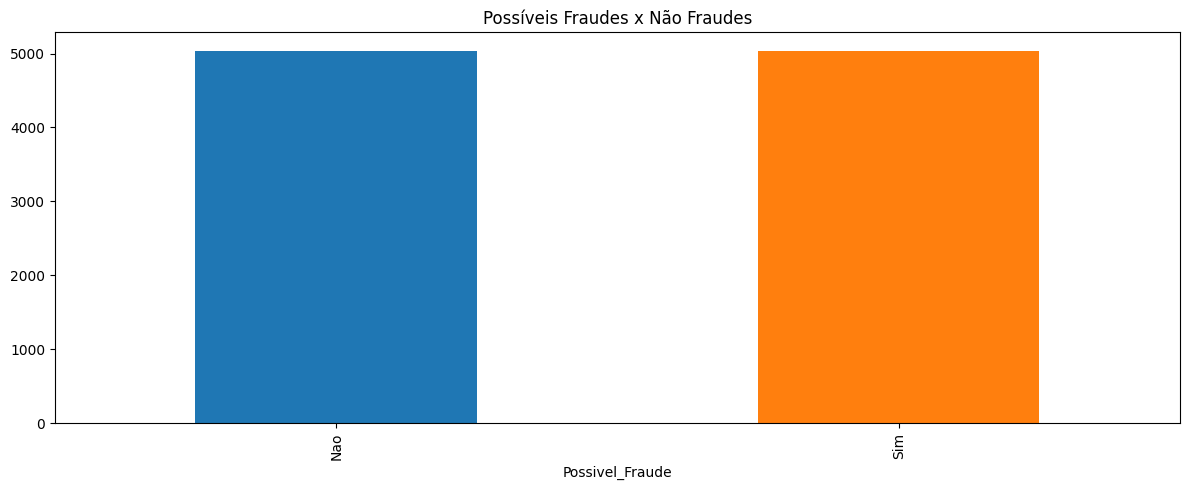

In [ ]:
# Visualizando o balanceamento da variável TARGET que é a variável principal
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Possíveis Fraudes x Não Fraudes',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(9517, 18)

In [ ]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(9517,)

In [ ]:
# Quantidade de registros após do balanceamento
PREDITORAS_RES.shape

(10070, 18)

In [ ]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(10070,)

## Agora vamos dividir os dados em dados de treino e teste para iniciarmos a etapa de criação do modelo

In [ ]:
# Divisão em Dados de Treino e Teste. Aqui utilizamos 30% de teste
X_treino, X_teste, Y_treino, Y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [ ]:
X_treino.shape

(7049, 18)

In [ ]:
X_treino.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Prazo_Restante,Faixa_Salarial,Faixa_Prazo_Emprestimo,Faixa_Etaria,Faixa_Dias_Atraso
7012,0,17,19.00,500000.00,575000.00,1,1,0,1,4,12,600296.26,1942.30,0,7,2,5,3
8541,0,25,20.00,140000.00,161000.00,5,3,1,1,0,8,167073.02,2485.00,0,6,2,5,2
3903,0,4,28.00,12000.00,13800.00,1,1,0,0,0,13,15717.44,332.66,1,6,1,2,0
1844,0,25,18.00,50000.00,57500.00,13,5,3,5,3,0,13084.40,26422.41,1,3,1,1,3
8303,1,9,21.00,15000.00,17250.00,13,3,4,1,3,0,14096.18,4423.11,1,6,1,2,3


In [ ]:
# Normalização das Variáveis é deixar todas na mesma escala vai deixar todos os dados entre 0 e 1. Não precisa normalizar e padronizar a variável TARGET que é a padrão
Normalizador = MinMaxScaler()
X_treino_normalizados = Normalizador.fit_transform(X_treino)
X_teste_normalizados = Normalizador.transform(X_teste)

In [ ]:
X_treino_normalizados.shape

(7049, 18)

In [ ]:
X_treino_normalizados

array([[0.        , 0.65384615, 0.57142857, ..., 0.66666667, 1.        ,
        0.5       ],
       [0.        , 0.96153846, 0.61904762, ..., 0.66666667, 1.        ,
        0.33333333],
       [0.        , 0.15384615, 1.        , ..., 0.33333333, 0.4       ,
        0.        ],
       ...,
       [1.        , 0.96153846, 0.71428571, ..., 0.66666667, 0.4       ,
        0.5       ],
       [1.        , 0.88461538, 0.57142857, ..., 0.66666667, 0.8       ,
        1.        ],
       [1.        , 0.96153846, 0.85714286, ..., 1.        , 0.8       ,
        0.5       ]])

In [ ]:
# Padronizacao das Variáveis
Padronizador = StandardScaler()
X_treino_padronizados = Padronizador.fit_transform(X_treino)
X_teste_padronizados = Padronizador.transform(X_teste)

In [ ]:
# Visualizando os dados PADRONIZADOS. Padronização é quando a média e desvio padrão ficam entre 0 e 1.
X_treino_padronizados

array([[-1.19681542,  0.23366629, -0.17570736, ..., -0.0233426 ,
         1.62609594,  0.21145893],
       [-1.19681542,  1.30019073,  0.08623913, ..., -0.0233426 ,
         1.62609594, -0.50688999],
       [-1.19681542, -1.49943592,  2.18181105, ..., -1.17398585,
        -0.6960982 , -1.94358782],
       ...,
       [ 0.83555073,  1.30019073,  0.61013211, ..., -0.0233426 ,
        -0.6960982 ,  0.21145893],
       [ 0.83555073,  1.03355962, -0.17570736, ..., -0.0233426 ,
         0.85203123,  2.36650569],
       [ 0.83555073,  1.30019073,  1.39597158, ...,  1.12730065,
         0.85203123,  0.21145893]])

# Criando, treinando e Avaliando os Modelos de ML

### Fazendo primeiro com Random Forest

In [ ]:
#Construtor do modelo
randomForest = RandomForestClassifier()

In [ ]:
#Parametros default
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Valores para o grid de hiperparametros de forma automatizada
n_estimators = np.array([100,200,300]) #pode colocar quantos parametros/numeros quiser. Quanto mais números mais modelos de treinamento e demora para processar.
max_depth = np.array([10,20])
criterion = np.array(["gini", "entropy"])
max_features = np.array(["sqrt", "log2", None])
min_samples_split = np.array([1,2,5])
min_samples_leaf = np.array([1,2,3])


# Grid de hiperparâmetros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth = max_depth,
                       criterion = criterion,
                       max_features = max_features,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

# Criando o modelo com o Grid de Hiperparametros , cv é validação cruzada no momento em que estiver treinando o modelo vai pegar cada amostra para ver qual se comporta melhor com determi
randomForest = GridSearchCV(randomForest, grid_parametros, cv = 3, n_jobs = 4) #num. 4 pq minha máquina é i core 3

# Treinando os modelos
inicio = time.time()
randomForest.fit(X_treino_normalizados, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {randomForest.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {randomForest.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_rf.shape[0])
#levou 805 segundos de tempo

Acurácia em Treinamento: 99.25%

Hiperparâmetros Ideais: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Tempo de Treinamento do Modelo:  805.9

Numero de treinamentos realizados:  324


In [ ]:
# Criando o classificador com Random Forest com os melhores parâmetros dados acima. Então aqui estamos treinado com apenas os parâmetros ideais. Por isso o carregamento se torna mais rápido tmb.
clf = RandomForestClassifier(n_estimators  = 300, criterion = 'entropy', max_depth = 20,
                             max_features = 'log2', min_samples_leaf = 1, min_samples_split = 2, n_jobs = 4)

# Construção do modelo
clf = clf.fit(X_treino_normalizados, Y_treino)

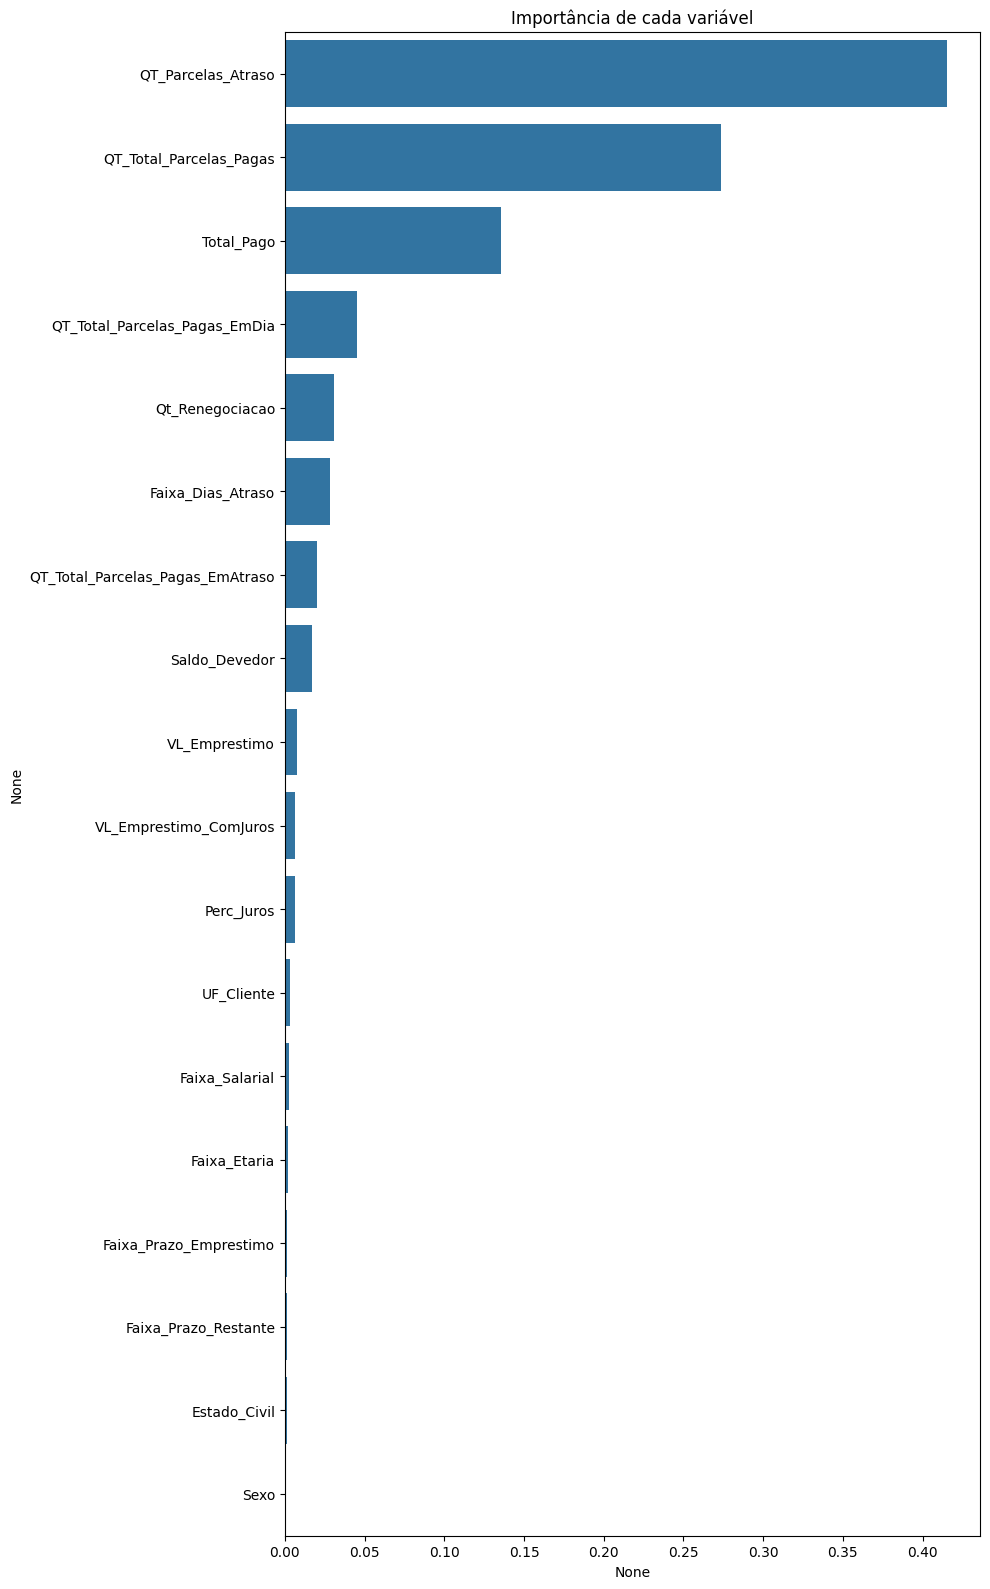

In [ ]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 16.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [ ]:
#Vendo em formas de números
# Visualizando o percentual de importancia de cada variável. Observamos que a partir de UF_Cliente podemos tirar essas variáveis que estão com 0 no próximo treinamento.
importances.sort_values(ascending = False)

QT_Parcelas_Atraso                 0.42
QT_Total_Parcelas_Pagas            0.27
Total_Pago                         0.14
QT_Total_Parcelas_Pagas_EmDia      0.05
Qt_Renegociacao                    0.03
Faixa_Dias_Atraso                  0.03
QT_Total_Parcelas_Pagas_EmAtraso   0.02
Saldo_Devedor                      0.02
VL_Emprestimo                      0.01
VL_Emprestimo_ComJuros             0.01
Perc_Juros                         0.01
UF_Cliente                         0.00
Faixa_Salarial                     0.00
Faixa_Etaria                       0.00
Faixa_Prazo_Emprestimo             0.00
Faixa_Prazo_Restante               0.00
Estado_Civil                       0.00
Sexo                               0.00
dtype: float64

In [ ]:
# Estamos apenas "simulando" os dados de teste
scores = clf.score(X_treino_normalizados,Y_treino)
scores

1.0

In [ ]:
# Estamos apenas "simulando" os dados de teste
scores = clf.score(X_teste_normalizados,Y_teste)
scores

0.9910625620655412

Observamos que entre as 2 simulações acima praticamente não há diferenças. Uma é 1 e a outra é 0,99. Significando que não há overfitting e há muita proximidade nas acurácias dele que são 1 e 0,99.

In [ ]:
# Dicionário de métricas e metadados
modelo_rf = {'Melhores Hiperparametros':randomForest.best_params_,
               'Numero de Modelos Treinados': treinos_rf.shape[0],
               'Melhor Score': str(round(randomForest.best_score_ * 100,2))+"%"}
modelo_rf

{'Melhores Hiperparametros': {'criterion': 'entropy',
  'max_depth': 20,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 300},
 'Numero de Modelos Treinados': 324,
 'Melhor Score': '99.25%'}

In [ ]:
# Construtor do modelo SVM
modelo_svm = SVC()

In [ ]:
# Parametros default
modelo_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
# Valores para o grid de hiperparametros
grid_parametros = {'C': [0.1,1,10,100],
                   'gamma': [1,0.1,0.01,0.001],
                   #'kernel': ['poly','rbf','sigmoid','linear'],
                   'degree' : [2,3,4,],
                   'coef0' : [0.5,1],
                   #'decision_function_shape':['ovo', 'ovr'],
                   'max_iter': [-1, 1]}


svm = GridSearchCV(modelo_svm, grid_parametros, n_jobs = 8)

# Treinando os modelos
inicio = time.time()
svm.fit(X_treino_normalizados, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_svm = pd.DataFrame(svm.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {svm.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {svm.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_svm.shape[0])

Acurácia em Treinamento: 98.92%

Hiperparâmetros Ideais: {'C': 100, 'coef0': 0.5, 'degree': 2, 'gamma': 0.01, 'max_iter': -1}

Tempo de Treinamento do Modelo:  326.64

Numero de treinamentos realizados:  192


In [ ]:
# Dicionário de métricas e metadados
modelo_svm = {'Melhores Hiperparametros':svm.best_params_,
               'Numero de Modelos Treinados': treinos_svm.shape[0],
               'Melhor Score': str(round(svm.best_score_ * 100,2))+"%"}

In [ ]:
#Vamos fazer agora com o KNN
# Classificador
knn = KNeighborsClassifier()

In [ ]:
# Parametros default
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
# Valores para o grid de hiperparametros
n_neighbors = np.array([3,4,5,6,7])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
leaf_size = np.array([30,31,32])
metric =  np.array(['minkowski','euclidean'])


# Grid de hiperparâmetros
grid_parametros = dict(n_neighbors = n_neighbors,
                       algorithm = algorithm,
                       leaf_size = leaf_size,
                       metric = metric)

knn = GridSearchCV(knn, grid_parametros, n_jobs = 8)

# Treinando os modelos
inicio = time.time()
knn.fit(X_treino_normalizados, Y_treino)
fim = time.time()

# Obtendo e visualizando os parametros treinados
treinos_knn = pd.DataFrame(knn.cv_results_)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {knn.best_score_ :.2%}")
print("")
print(f"Hiperparâmetros Ideais: {knn.best_params_}")
print("")
print("Tempo de Treinamento do Modelo: ", round(fim - inicio,2))
print("")
print("Numero de treinamentos realizados: ", treinos_knn.shape[0])

Acurácia em Treinamento: 97.04%

Hiperparâmetros Ideais: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5}

Tempo de Treinamento do Modelo:  121.57

Numero de treinamentos realizados:  120


In [ ]:
# Dicionário de métricas e metadados
modelo_knn = {'Melhores Hiperparametros':knn.best_params_,
               'Numero de Modelos Treinados': treinos_knn.shape[0],
               'Melhor Score': str(round(knn.best_score_ * 100,2))+"%"}

In [ ]:
# Gerando o DataFrame com todos os valores de todos os modelos treinados
resumo = pd.DataFrame({'Random Forest':pd.Series(modelo_rf),
                       'SVM':pd.Series(modelo_svm),
                       'KNN':pd.Series(modelo_knn)})

In [ ]:
resumo
#saída será um dataframe

,Random Forest,SVM,KNN
Melhores Hiperparametros,"{'criterion': 'entropy', 'max_depth': 20, 'max...","{'C': 100, 'coef0': 0.5, 'degree': 2, 'gamma':...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Numero de Modelos Treinados,324,192,120
Melhor Score,99.25%,98.92%,97.04%


## Concluímos que o melhor modelo é o Random Forest. Pois tem o melhor score e uma melhor acuracia , então concluímos nosso pipeline completo do nosso modelo preditivo de ML.